In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os
import sys
from scipy.stats import t

In [2]:

def stat_error(data, conf_prob=0.99):
    #conf_prob - Доверительная вероятность  
    n = data.shape[1]
    student_coef = round(t.ppf((1 + conf_prob )/2, n - 1), 2)
    var = np.var(data, axis=1)
    interval = student_coef * np.sqrt((var)/n)
    return interval
    

# Задание 1
Создание визитки 

В отчёте просили перевести среднюю мощность лазера для каждого цвета,в плотность мощности, а также рассчитать перекрытие

In [3]:
# длительность импульса в секундах
t_pls = 100*1e-9
#Диаметр лазерного пятна при идеальной фокусировке см
d_id = 50*1e-4
#скорость в словаре в см/c
#средняя мощность в долях от максимальной 
Pws =  {'Черный' : [0.60,  5,    20e+3],
        'Красный': [0.31,  2.6,  96e+3],
        'Желтый' : [0.32,  4.2,  40e+3],
        'Зеленый': [0.37,  1.5,  59e+3],
        'Синий'  : [0.32,  3.6,  48e+3],
        'Фиолет' : [0.30,  2.9,  90e+3],
        'Белый'  : [0.60,  100, 60e+3]}
#Плотность мощгность в Вт/см^2
Pw_den = np.array([20*item[0]/(t_pls*item[2]*np.pi*d_id**2/4) for item in Pws.values()])
#Смещение Lx в %
L_x = np.array([(1 - item[1]/(item[2]*d_id))*100 for item in Pws.values()])

In [4]:
print(Pw_den)
print(L_x)

[3.05577491e+08 3.28920216e+07 8.14873309e+07 6.38777805e+07
 6.79061091e+07 3.39530545e+07 1.01859164e+08]
[95.         99.45833333 97.9        99.49152542 98.5        99.35555556
 66.66666667]


# Задание 2
а)Измерить диаметр зоны абляции
материала. Также измерить ширину линий для различных материалов.
По результатам измерений вычислить диаметр пучка в фокальной
плоскости df и пороговую плотность мощности испарения материала F0,
сравнить экспериментальные данные с теоретическим расчетом.
Построить график зависимости диаметра абляции от плотности
мощности, а также графики зависимости ширины линии от параметров
лазерного излучения для керамики и нержавеющей стали.

б)Выполнить микроструктурирование нержавеющей стали и керамики
Al2O3. Для этого подобрать параметры лазерного излучения (скорость,
частоту, расстояние между линиями) таким образом, чтобы обеспечить
приведенные в таблице значения перекрытий (Lx – расстояние между
импульсами по оси X, Ly – расстояние между импульсами по оси Y, d –
диаметр пучка в фокусе)

## пункт а

В пункте а, мы, изменяя мощность с шагом в 10%(максимальная мощьность - 20Вт), выполнили микроструктурирования стали и керамики, структуры представляют из себя прямыге линии. Все фотографии находятся на яндекс диске https://disk.yandex.ru/d/I3Y9IdaPHVObtg Для стали фотографии находятся в папке a/point_a/steal , а для керамики в папке data/point_a/ceramics.C помощью программы ,были измерены  по три диаметра ванн расплава. и  представлены в виде матрицы st в мкм

In [5]:
st = np.array([[73.26, 66.60, 70.29], 
               [62.13, 66.57, 59.22],
               [63.31, 64.29, 60.29],
               [61.62, 58.34, 54.77],
               [56.61, 53.61, 60.56],
               [52.04, 50.62, 50.80],
               [43.57, 41.05, 45.58],
               [32.70, 33.26, 35.26]])

cer = np.array([[65.51, 67.15, 59.57],
                [67.87, 56.64, 62.44],
                [54.06, 60.88, 55.74],
                [54.94, 57.25, 48.65],
                [46.86, 45.91, 45.85],
                [48.87, 40.41, 42.78],
                [30.82, 36.16, 29.81]])

#мощность лазера в Вт
#у нас получилось разное количество картинок для керамики и стали, 
#поэтому и мощностей две полосы(для удобства и точности расчётов)
power_st = np.arange(20, 4, -2)
power_cer = np.arange(20, 6, -2)
# длительность импульса в секундах
t_pls = 100*1e-9
f_pls = 20*1e+3
#Диаметр лазерного пятна при идеальной фокусировке см
d_id = 50*1e-4

In [6]:
#Вычислим средние размеры ванны в каждой линии 
st_m = np.mean(st, axis=1)
cer_m = np.mean(cer, axis=1)
st_err = stat_error(st, conf_prob=0.66)
cer_err = stat_error(cer, conf_prob=0.66)

Необходимо определить диаметр пучка в фокальной плоскости $d_f$ и пороговую плотность мощности испарения материала $F_0$

Для этого необходимо подобрать параметры следующей аппроксимирующей кривой

$d_{abb} = d_{f}\cdot\sqrt{\frac{1}{2}\cdot\ln{\frac{F}{F_{0}}}}\newline$ 
где 
$F - плотность\quadмощности\quadпадающего\quadизлучения \quad (\frac{мощность \quad лазера}{см^2})\newline  
F_{0} - пороговая \quad плотность \quad мощности \quad испарения \quad вещества \newline 
d_{f} - диаметр\quad  пятна \quad в \quad фокусе \quad в \quad мкм\newline
d_{abb} - диаметр \quad ванны \quad аббляции$ 

In [7]:
#Кривые две, поэтому значений d_f будет 2, возьмём потом среднее 
#(диаметр пятна в фокусе же в обоих случаях один и тот же)
#Кроме того, отношение в логарифме уничтожает отношение площадей, поэтому можно спокойно 
#подставлять мощность, а не плотность мощности.
[d_st, P_st],cov = curve_fit(lambda x, d_st, P_st:d_st*np.sqrt(np.log(x/P_st)/2), 
                        power_st, st_m, 
                        maxfev=100000)
err_d_st, err_P_st, = np.sqrt(np.diag(cov))

[d_cer, P_cer],cov = curve_fit(lambda x, d_cer, P_cer:d_cer*np.sqrt(np.log(x/P_cer)/2),
                        power_cer, cer_m, 
                        maxfev=100000)
err_d_cer, err_P_cer, = np.sqrt(np.diag(cov))

/tmp/ipykernel_2736/1503841863.py:5: RuntimeWarning: invalid value encountered in sqrt
  [d_st, P_st],cov = curve_fit(lambda x, d_st, P_st:d_st*np.sqrt(np.log(x/P_st)/2),
/tmp/ipykernel_2736/1503841863.py:5: RuntimeWarning: invalid value encountered in log
  [d_st, P_st],cov = curve_fit(lambda x, d_st, P_st:d_st*np.sqrt(np.log(x/P_st)/2),
/tmp/ipykernel_2736/1503841863.py:10: RuntimeWarning: invalid value encountered in sqrt
  [d_cer, P_cer],cov = curve_fit(lambda x, d_cer, P_cer:d_cer*np.sqrt(np.log(x/P_cer)/2),
/tmp/ipykernel_2736/1503841863.py:10: RuntimeWarning: invalid value encountered in log
  [d_cer, P_cer],cov = curve_fit(lambda x, d_cer, P_cer:d_cer*np.sqrt(np.log(x/P_cer)/2),


In [8]:
power_2 = np.linspace(6, 20, num=1000 )
st_ap = d_st*np.sqrt(np.log(power_2/P_st)/2)
cer_ap = d_cer*np.sqrt(np.log(power_2/P_cer)/2)

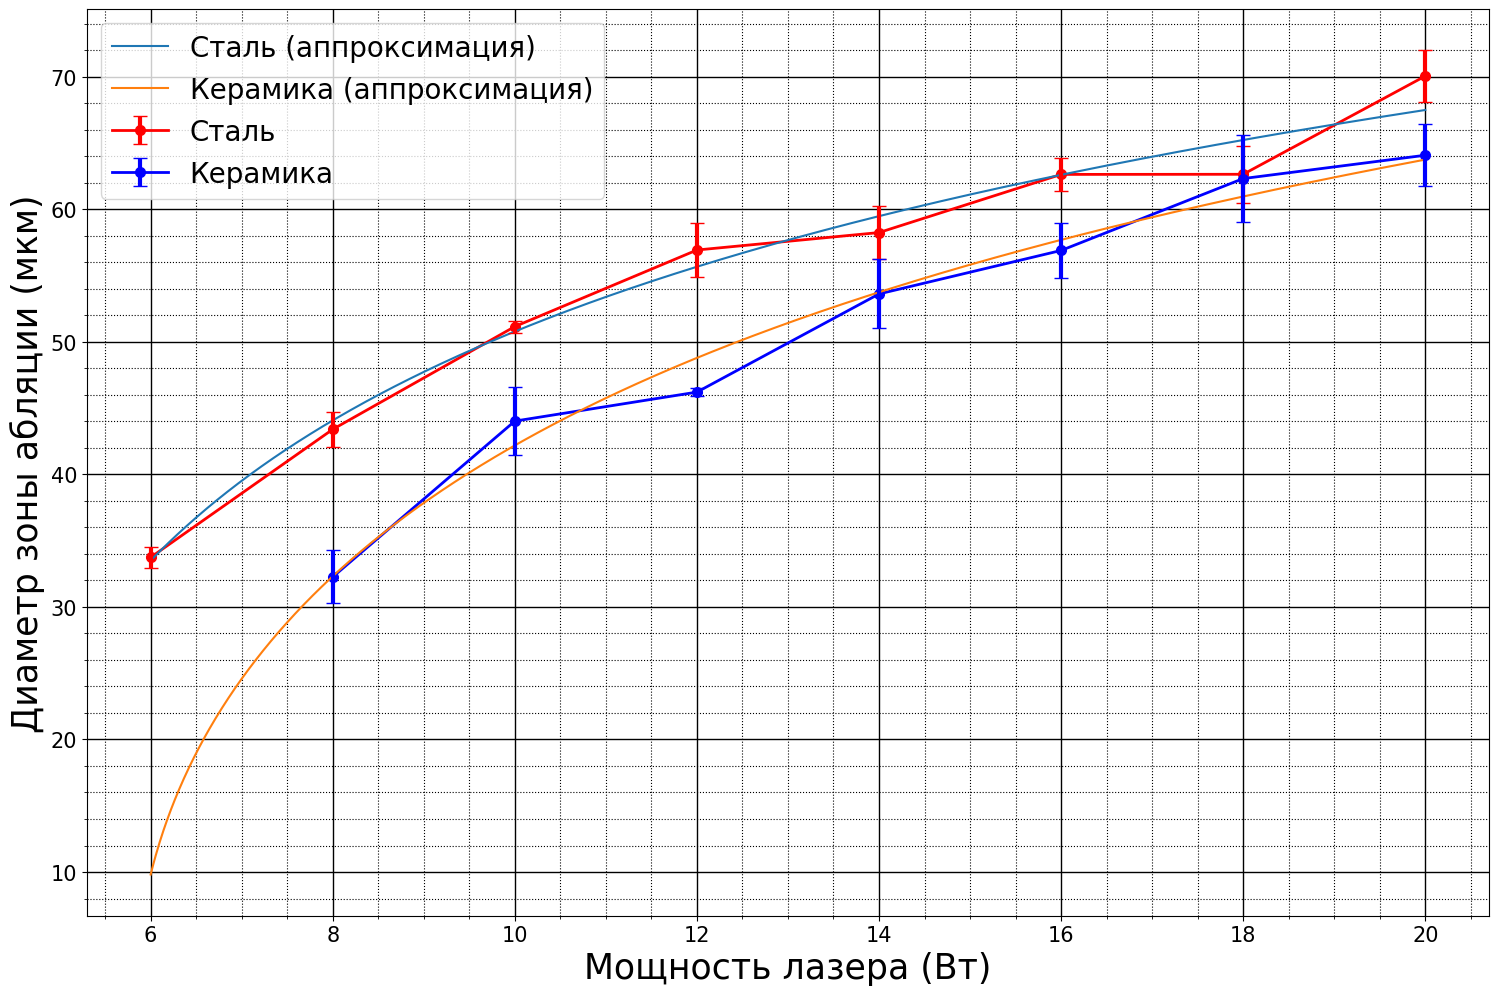

In [9]:
#Аппроксимационные кривые 
#Важно, что зависимость здесь берётся именно от мощности, а не от плотности 
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Диаметр зоны абляции (мкм)',fontweight='light',color='k', fontsize=25)
ax.set_xlabel("Мощность лазера (Вт)", fontweight='light',color='k', fontsize=25)

ax.plot(power_2,st_ap, label="Сталь (аппроксимация)")
ax.plot(power_2,cer_ap, label="Керамика (аппроксимация)")
ax.errorbar(power_st, st_m, yerr=st_err, color='r', label="Сталь", fmt='-o',barsabove=True,
            ms=7, capsize = 5,
            linewidth=2,
            elinewidth = 3)

ax.errorbar(power_cer, cer_m, yerr=cer_err, color='b', label="Керамика", fmt='-o',barsabove=True,
            ms=7, capsize = 5,
            linewidth=2,
            elinewidth = 3)

#  Определяем внешний вид линий основной сетки:
ax.grid(which='major',
        color = 'k', 
        linewidth = 1)

ax.legend(fontsize=20, loc='upper left')

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.minorticks_on()
ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')


plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)
fig.savefig(os.path.join(sys.path[0]+'/plots', 'st_cer_ap.png'))

$d_{st}\quad и \quad d_{cer}$ - фокусные диаметры для стали и кермики соответственно$\newline$
$ P_{st}\quad и\quad P_{cer}$ - средние пороговые мощности лазера $\newline$
$f$ - частота следования импульсов $\tau $ - импульсов

$Пороговая\quad плотность \quad мощности \quad испарения \quad $(например стали)$\quad F_{0st} = \frac{P_{st}}{f\cdot\tau\cdot\frac{\pi\cdot d_{st}^2}{4}} $

погрешность вычисляется по формулам $\Delta d_{f} = \frac{1}{2}\cdot\sqrt{\Delta d_{st}^2 + \Delta d_{cer}^2 }\newline \Delta F_{0st} = \frac{4\cdot F_{st}}{f\cdot\tau\cdot\pi\cdot d_{st}^2}\sqrt{({\frac{\Delta F_{st}}{F_{st}}})^2 +({\frac{\Delta d_{f}}{d_{f}}})^2}$

In [10]:
#df - в мкм 
#F_0 - в Вт/см^2

d_f = np.mean(np.array([d_st, d_cer]))
err_d_f = np.sqrt((err_d_st)**2 + (err_d_cer)**2)
F_0_st = P_st/(f_pls*t_pls * np.pi*(d_f*1e-4)**2/4)
err_F_0_st = F_0_st*np.sqrt((err_P_st/P_st)**2 +(err_d_f/d_f)**2)
F_0_cer = P_cer/(f_pls*t_pls * np.pi*(d_f*1e-4)**2/4)
err_F_0_cer = F_0_cer*np.sqrt((err_P_cer/P_cer)**2 +(err_d_f/d_f)**2)

погрешность будет  
$\newline \Delta F = F\cdot\delta d_f $

In [11]:
#Посчитаем плотность мощности для 
pow_den_st = power_st/(f_pls*t_pls*np.pi*d_f**2*1e-8/4) 
err_pow_den_st = pow_den_st * err_d_f / d_f
pow_den_cer = power_cer/(f_pls*t_pls*np.pi*d_f**2*1e-8/4) 
err_pow_den_cer = pow_den_cer * err_d_f / d_f

In [12]:
#Переведём в плотность в МВт/см^2 
pow_den_st *= 1e-6
err_pow_den_st *= 1e-6
pow_den_cer *= 1e-6
err_pow_den_cer *= 1e-6

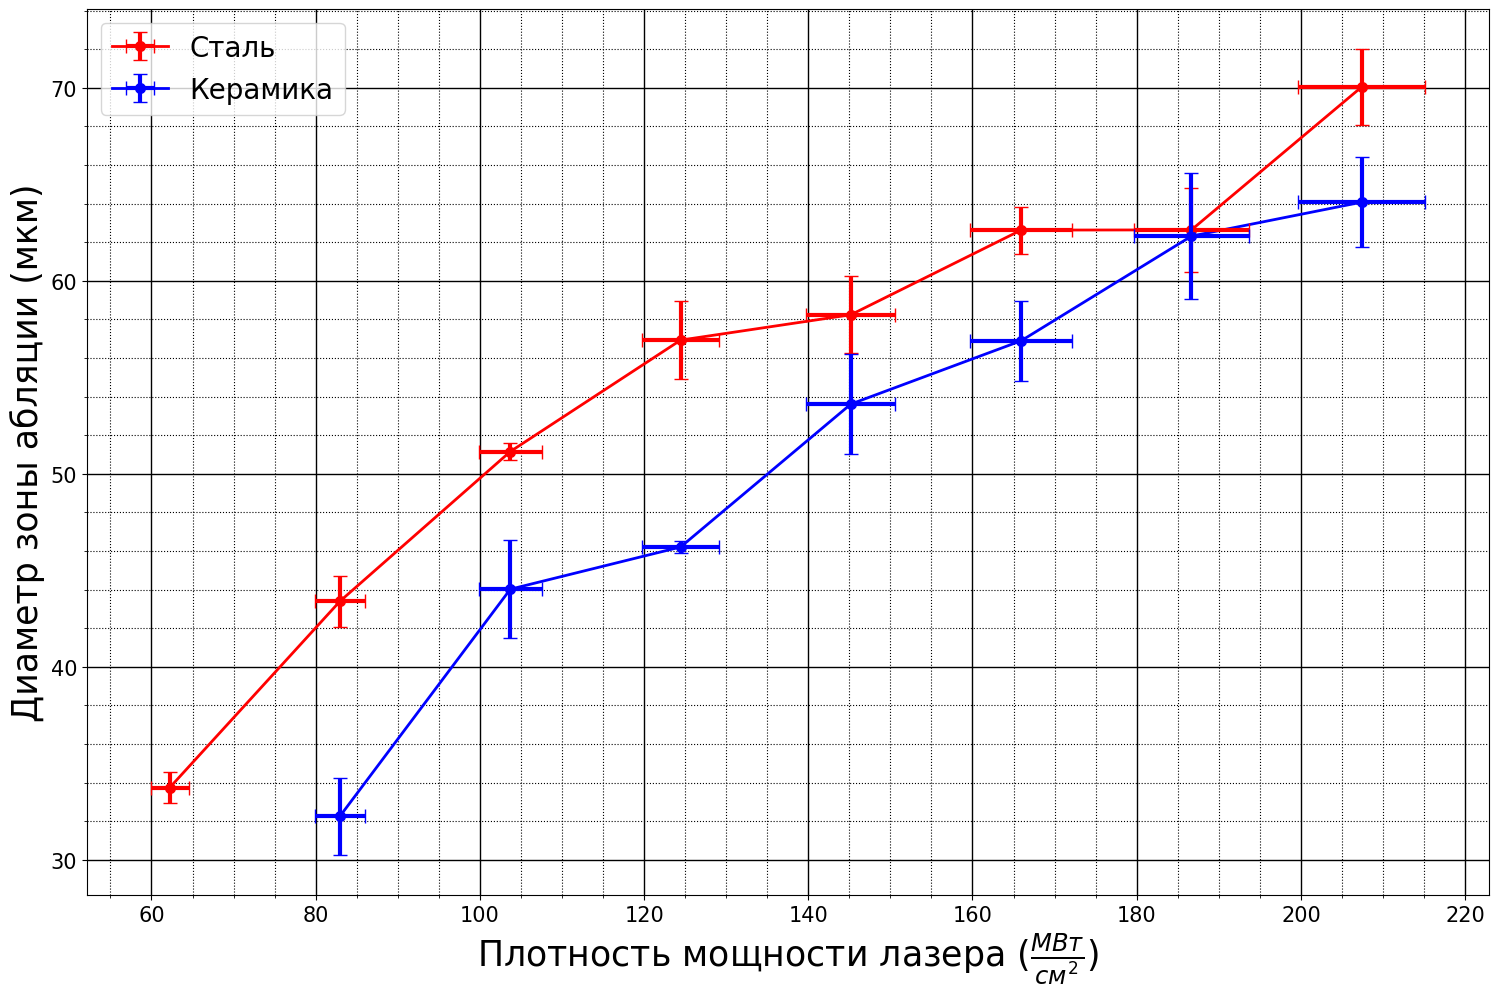

In [13]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)
ax.set_ylabel('Диаметр зоны абляции (мкм)',fontweight='light',color='k', fontsize=25)
ax.set_xlabel(r'Плотность мощности лазера $(\frac{МВт}{см^2})$',fontweight='light',color='k', fontsize=25)

ax.errorbar(pow_den_st, st_m, yerr=st_err, xerr= err_pow_den_st, color='r', label="Сталь", fmt='-o',barsabove=True,
            ms=7, capsize = 5,
            linewidth=2,
            elinewidth = 3)

ax.errorbar(pow_den_cer, cer_m, yerr=cer_err, xerr= err_pow_den_cer, color='b', label="Керамика", fmt='-o',barsabove=True,
            ms=7, capsize = 5,
            linewidth=2,
            elinewidth = 3)

#  Определяем внешний вид линий основной сетки:
ax.grid(which='major',
        color = 'k', 
        linewidth = 1)

ax.legend(fontsize=20, loc='upper left')

#  Определяем внешний вид линий вспомогательной
#  сетки:
ax.minorticks_on()
ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')


plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=15)

fig.savefig(os.path.join(sys.path[0]+'/plots', 'st_cer.png'))

In [14]:
print("Пятно в фокальной области =", d_f, "мкм")
print("Абсолютная погрешность пятна в фокальной области =", err_d_f, "мкм")
print("Пороговая плотность мощности испарения стали =",  F_0_st, "Вт/cm^2" )
print("Абсолютная погрешность порогоой плотности мощности испарения стали =", err_F_0_st, "Вт/cm^2")
print("Пороговая плотность мощности испарения стали =",  F_0_cer, "Вт/cm^2" )
print("Абсолютная погрешность порогоой плотности мощности испарения стали =",  err_F_0_cer, "Вт/cm^2")

Пятно в фокальной области = 78.35026599702053 мкм
Абсолютная погрешность пятна в фокальной области = 2.9245232058054267 мкм
Пороговая плотность мощности испарения стали = 41982198.07910005 Вт/cm^2
Абсолютная погрешность порогоой плотности мощности испарения стали = 2632266.6758773 Вт/cm^2
Пороговая плотность мощности испарения стали = 60431238.42183246 Вт/cm^2
Абсолютная погрешность порогоой плотности мощности испарения стали = 3357662.839494681 Вт/cm^2


Видно, что пятно в фокальной области в пределах погрешности не сходится с размером пятна, указанным в документаци. .Это вполне может быть связано с тем, что мы криво установку настроили.

К решению этой задачи можно было бы подойти и иначе - посмотреть, при какой мощность пропадает кратер (на картинке) и  взять ее за пороговую.  а потом уже найти только один параметр - диаметр пятна в фокальной плоскости. Но вообще хороший вопрос, насколько это (не)точнее, чем метод, которым пользовался я.

Задача для Гриши - Найти теоретические значения для пороговой плотности мощности испарения обоих веществ

## пункт б

В пункте б (на яндекс диске /data/point_b) мы с фиксированной мощностью лазера выполняли микроструктурирования, изменяя перекрытия Lx.
Величины этих перекрытий указаны в лабнике. (Однако в  заданиии лабника это не перекрытия, а иемнно расстояния между центрами соседних импульсов)
Формула перекрытия 
$L_x = (1 - \frac{v_{ск}}{f\cdot d})$$\newline $ Где $\newline$ $v_{ск} - скорость\quad сканирования$  $\newline$ $f - частота\quad следования\quad импульсов$$\newline$$d - диаметр пятна$

Честно говоря, эту установку после предыдущих измерений столько раз перенастраивали, 
что лучшим вариантом будеи диаметр пятна из документации к установки - 50 мкм 

Вроде как частота следования импульсов стояла одна и та же, значит мы меняли только скорость скорость  

### Структура 1

$L_x = d\quad L_y=d \quad $ Значит перекрытие равняется = 0, следовательно  если при установленной частоте импульсов f в 50 кГц, скорость сканирования должна быть  $v_{cк} = d\cdot f  = 50 \cdot 10^{-4}см \cdot 50 кГц=  250 \frac{см}{с}$ При этом для достижения такого расстояния$(L_y)$ по оси y нужно выставить 200 лин на мм  

$L_x = \frac{d}{3}\quad L_y=2d \quad $ Значит перекрытие равняется = 0, следовательно  если при установленной частоте импульсов f в 50 кГц, скорость сканирования должна быть  $v_{cк} = \frac{d}{3}\cdot f  = \frac{50}{3} \cdot 10^{-4}см \cdot 50 кГц=  84 \frac{см}{с}$ При этом для достижения такого расстояния$(L_y)$ по оси y нужно выставить 100 лин на мм  

$L_x = d\quad L_y=\frac{d}{2} \quad $ Значит перекрытие равняется = 0, следовательно  если при установленной частоте импульсов f в 50 кГц, скорость сканирования должна быть  $v_{cк} = d\cdot f  = 50 \cdot 10^{-4}см \cdot 50 кГц=  250 \frac{см}{с}$ При этом для достижения такого расстояния$(L_y)$ по оси y нужно выставить 400 лин на мм

Я это задание почти не помню, какие именнно значения мы брали, но считали так 